<h1>The hidden taste of US zip codes</h1>

<p>
As the final part of the courses, our task is to choose a project using location data and research an area based on the data I get.

I personally passionate about food, So why not try to combine, location of restaurants and find some hidden information there.
In this project, I'm going to explore different US states by zip codes; For each of those we are going to retrieve information about the restaurants around.
I hope to identify a difference in the taste of the population between different states and different zip codes based on the types of restaurants.

I wanted to add some economical information on top of that but couldn't find any good data source by zip codes.
So I decided to take a different approach and use house values by zip code, the data is available via Zillow.
we will explore a correlation between food types and the house values as an indicator of the correlation between food type and income
</p>

<h2>Business Justification</h2>
<p>
Using the information of different restaurants we can try and identify whether a new restaurant of any kind should be opened in this zip code.This is actually a hard question to answer but maybe the data can help and reveal the taste or the preferences people have around a certain area.
We may try and explore if in a certain area, for example in a city we have a different taste across zip codes, or maybe taking smaller proximity of a few kilometers and find if the taste is the same.If for example, we have found out that all zip codes except a few have a certain type of restaurant maybe the others have an opportunity.
<br />
Since I'm using housing price as a benchmark for economical data I'll try and explore if there is a correlation between the number of restaurants in a zip code and the prices of the house. Further research can dive and see if certain types of restaurants correlate for higher prices. it's probably will be more of an identification of the taste that people in those zip codes have than a certain indicator for the pricing.</p>
</p>

<h3> Part 1 - Getting the data: </h3>
<p>
    First we need to find all our data sources.
    For the resturant, and as requested by the assignment, we are going to utilize the forsquare API.
    <br />
    The zip code data base with corresponding geo location was found on opendatasoft
</p>
    <a href="https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/">US Zip Code Latitude and Longitude</a>
<p>
    The values of the houses data was downloaded from zillow research, here is a link for their page.
    The data included historical values dated back to 1998, I stripped everything and left only with the latsets numbers.
</p>
    <a href="https://www.zillow.com/research/data/">Zillow Research</a>

<p>
    Lets load both of the data sources and combine them into one data frame.
    We can use the zip code as a key.
    After loading the data into pandas frame we will explore it statisticly before diving into the research.
</p>

In [3]:
import numpy as np
import pandas as pd

# import plotting libraries to explore the data
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
import seaborn as sns;

In [3]:
# add houes prices and see if we can tell anything
hourses_data = 'zipcodes_us_house_values.csv'
zipcodes = 'us-zip-code-latitude-and-longitude.csv'

# in the houses csv the region name is the zip code
# 2020-10-31 -> this is the price information date and the column named accordinaly
houses_df = pd.read_csv(hourses_data, usecols=['RegionName', '2020-10-31'])
# lets rename the columns 
houses_df.columns = ['Zip', 'House Value']
# zip code csv use ; as sperator instead of ,
zipcodes_df = pd.read_csv(zipcodes, usecols=['Zip', 'City', 'State', 'Latitude', 'Longitude'], sep=';')

# lets print the shapes
print('houses df {}; zip codes: {}'.format(houses_df.shape, zipcodes_df.shape))

# we can see that the houses data base is actually smaller, since we want to work with samller database size anyway I will jsut drop those
# lets join the two data frames by the key zip code

# set indexes in both frames
houses_df.set_index('Zip')
zipcodes_df.set_index('Zip')

# merge by the indexes
grouped_df = zipcodes_df.merge(houses_df, on='Zip', how="left")

# remove all rouse with null house values
grouped_df = grouped_df[~grouped_df['House Value'].isnull()]

grouped_df.describe()

houses df (30230, 2); zip codes: (43191, 5)


,Zip,Latitude,Longitude,House Value
count,30006.000000,30006.000000,30006.000000,3.000600e+04
mean,48779.617976,38.749446,-90.279066,2.344904e+05
std,27372.050638,4.879588,14.333850,2.435980e+05
min,501.000000,17.734211,-165.108830,1.393500e+04
25%,25972.250000,35.451198,-96.288038,1.073208e+05
50%,48344.000000,39.535664,-87.645985,1.704090e+05
75%,71602.750000,42.033992,-80.008192,2.761215e+05
max,99929.000000,64.926041,-64.734694,8.804117e+06


In [7]:
# First thing lests check the the number of stated we have match the number of stated in the US
print('Number of states id DF: {}'.format(len(grouped_df['State'].unique())))

Number of states id DF: 53


In [8]:
# checking the numbers of states we can see we recived 54 states, which at least for me doesn't make sence.
# using wikipedia I have found out that there are 5 inhabited territories realted to the us but they are not part of the 50 states
# https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States
# I decided to check if they exists and if so remove them, 3 of them where in the list

list = ['AS', 'GU', 'MP', 'PR', 'VI']
for state in list:
    rows = len(np.where(grouped_df['State'] == state)[0])
    print("Delete {} row of state {}".format(rows,state))
    grouped_df = grouped_df[grouped_df['State'] != state]

# after runing the code lest print the number of states again
print('Number of states id DF: {}'.format(len(grouped_df['State'].unique())))

Delete 0 row of state AS
Delete 0 row of state GU
Delete 0 row of state MP
Delete 9 row of state PR
Delete 3 row of state VI
Number of states id DF: 51


In [9]:
# Actually DC counts as another state and not part of the 50 state
# we can just check if it's now part of the 51 states we have
print('Doest DC exists? ', np.any(grouped_df['State'] == 'DC'))

Doest DC exists?  True


<h3>Part 2 : Exploring the data</h3>
<p>
    After retriving and formation the data lets check how it distributed
    Lets plot the houses price by state and check it's seems legit.
    <br />
    We can also plot the map of all the zip codes, since the DF contains zip codes accross the US we should see the whole US covers in markers
    <br />
    The results of this part are bellow, we can see that our houses values differ between stated but the mostly keep the same shape.
    We can see that DC has more expensive houses on avarge
    And the state of WV has the least expensive
    <br />
    By looking at the map we can see that we have our markers split across the whole US map, so we can assume our zip code data is correct.
</p>

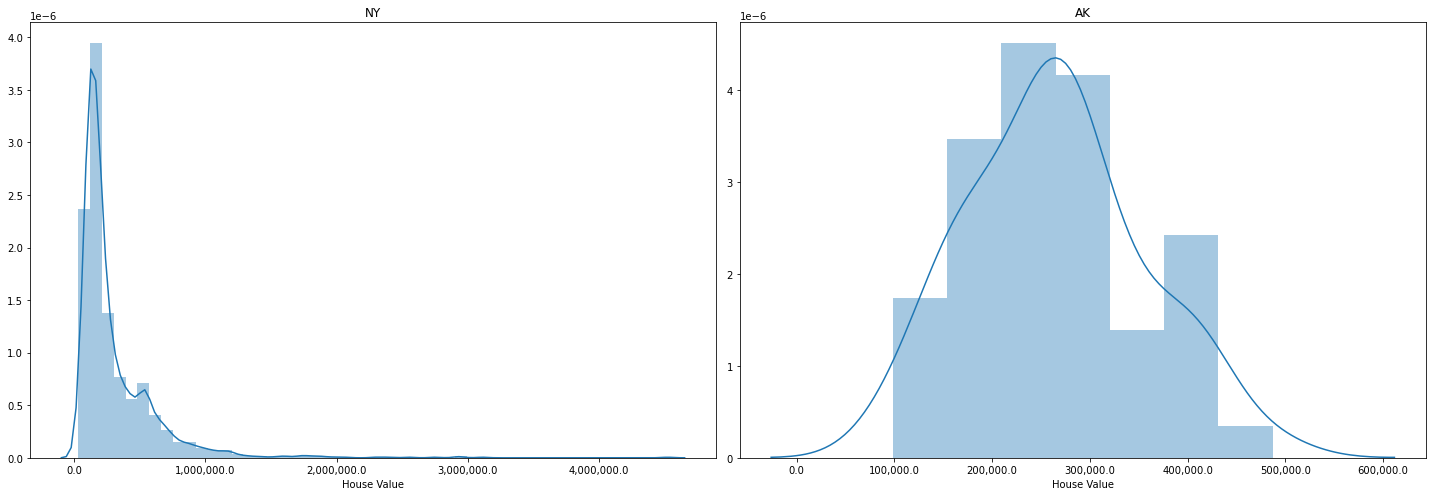

In [224]:
# visualizing houses prices
from matplotlib import pyplot as plt
import matplotlib as mpl
import math

fig = plt.figure(figsize=(20, 7))

# by observing the houses prices we can see that most of them is in the range of 0 -> 1.5 mil usd
# we have out liers from 5 mil and above

states_array = ['NY', 'AK']

rows = math.ceil(len(states_array) / 2)
col = 2
idx = 2
# we can explore this by state to see if we find any diffrences
for i, state in enumerate(states_array):
    state_df = grouped_df[grouped_df['State'] == state]
    idx = 2 if idx == 1 else 1 # it can be 1 or 2 since we have only two columns
    fig.add_subplot(rows,col,i+1)
    ax = sns.distplot(state_df['House Value'])
    ax.set_title(state)
    #print('Avg house value in {}: {}'.format(state, state_df['House Value'].mean()))
    plt.tight_layout()
    
    ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
    
fig.savefig('ny-ak-comp',bbox_inches='tight')

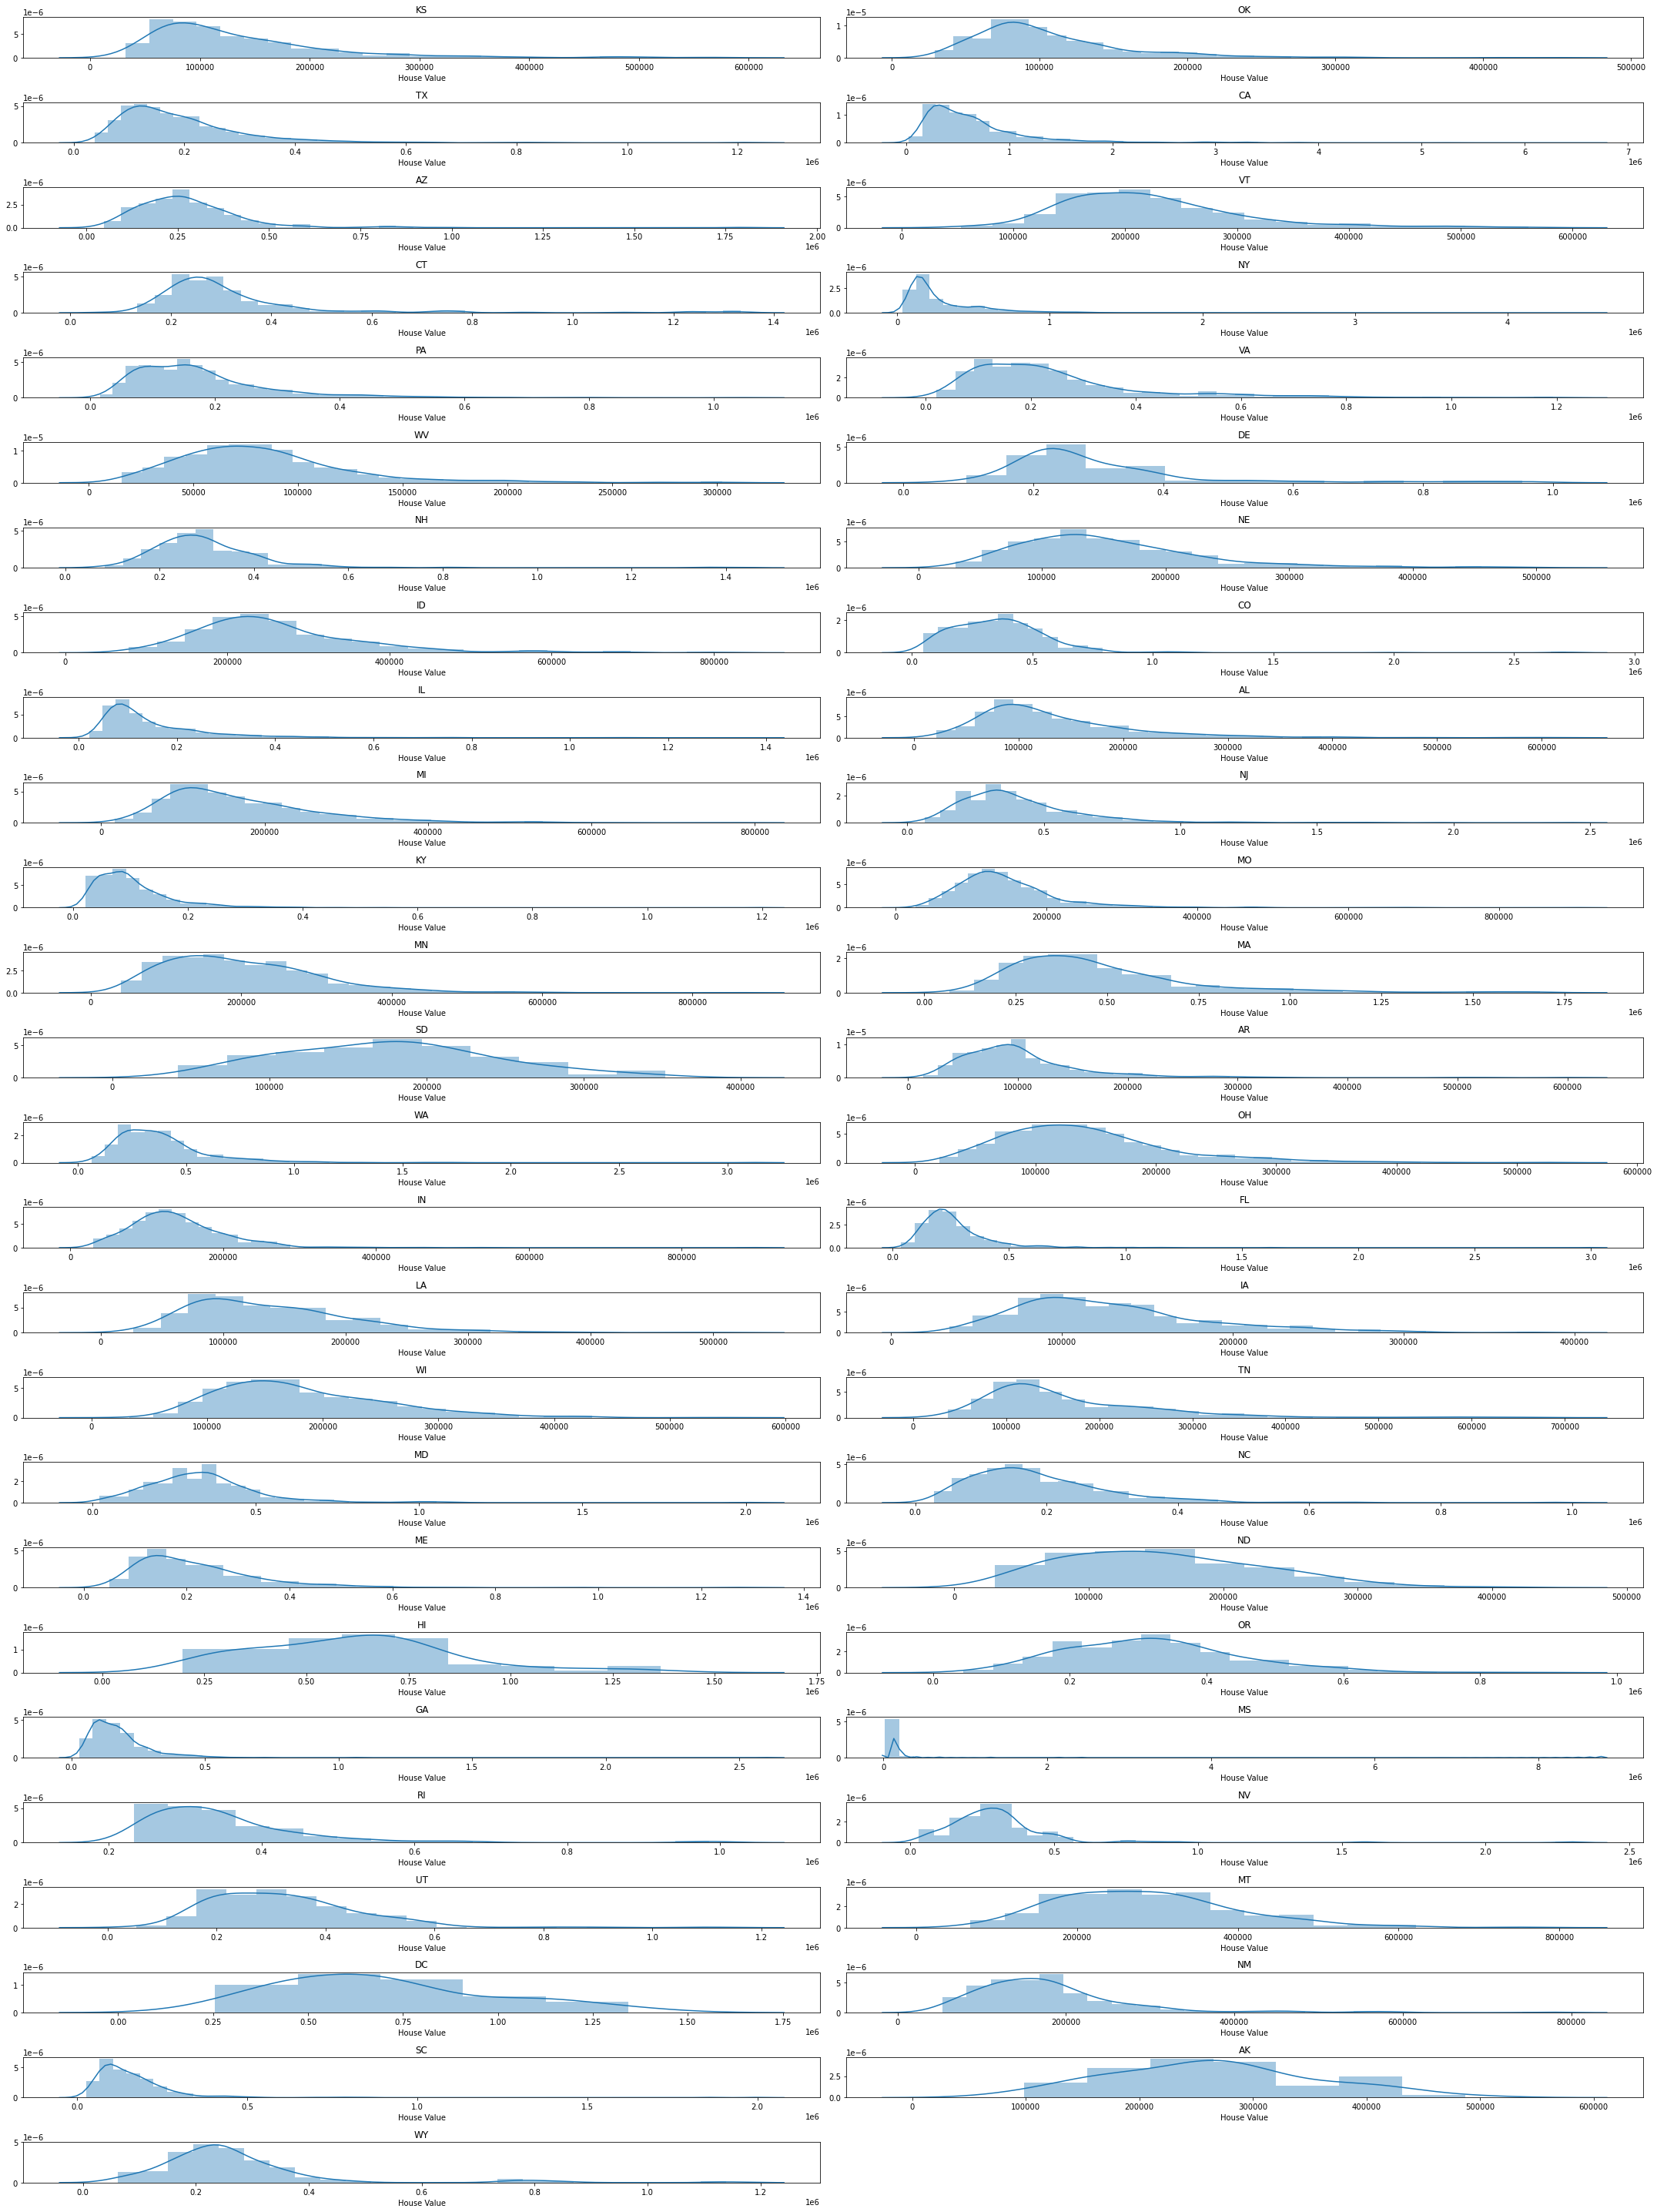

In [35]:
# visualizing houses prices
from matplotlib import pyplot as plt
import math

fig = plt.figure(figsize=(30, 40))

# by observing the houses prices we can see that most of them is in the range of 0 -> 1.5 mil usd
# we have out liers from 5 mil and above

states_array = grouped_df['State'].unique()

rows = math.ceil(len(states_array) / 2)
col = 2
idx = 2
# we can explore this by state to see if we find any diffrences
for i, state in enumerate(states_array):
    state_df = grouped_df[grouped_df['State'] == state]
    idx = 2 if idx == 1 else 1 # it can be 1 or 2 since we have only two columns
    fig.add_subplot(rows,col,i+1)
    sns.distplot(state_df['House Value']).set_title(state)
    #print('Avg house value in {}: {}'.format(state, state_df['House Value'].mean()))
    plt.tight_layout()


In [48]:
# lets create a df grouped by state with avarage house prices
house_values = grouped_df.groupby(['State']).mean().sort_values(by=['House Value'])
house_values = house_values.style.format({'House Value': '{0:,.2f}$'})
house_values

,Zip,Latitude,Longitude,House Value
State,,,,
WV,25788.028662,38.583062,-80.843706,"83,429.84$"
AR,72163.621670,35.155862,-92.425664,"103,709.36$"
KY,41346.048780,37.580531,-84.890207,"105,111.51$"
OK,73971.272285,35.479631,-96.988845,"105,549.66$"
IA,51261.383891,42.049484,-93.355783,"128,533.90$"
AL,35954.223881,32.930624,-86.791115,"132,949.67$"
KS,66900.913386,38.349027,-96.730951,"134,313.26$"
LA,70780.250564,30.935908,-91.798336,"139,696.49$"
IN,47008.871250,39.955509,-86.274008,"141,092.83$"


In [ ]:
import folium;
from folium.plugins import MarkerCluster

# just chose a random latitude of the fist location
latitude = grouped_df[grouped_df['State'] == states_array[0]]['Latitude'].mean()
longitude = grouped_df[grouped_df['State'] == states_array[0]]['Longitude'].mean()
    
# create map using latitude and longitude values
test_map = folium.Map(location=[latitude, longitude], zoom_start=10, prefer_canvas=True)

def generate_map(df, state, color):
    map_set = df[df['State'] == state]
    # create a market cluster
    marker_cluster = MarkerCluster().add_to(test_map)
    # add markers to map
    for row in range(0, len(map_set)):
        zipcode, city, state, lat, lng = map_set.iloc[row][['Zip', 'City', 'State', 'Latitude', 'Longitude']]
        label = '{}, {}, {}'.format(city, state, zipcode)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5.0,
            popup=label,
            color=color,#'blue',
            fill=True,
            fill_color=color,#'#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster)

        
# creaate a list of color, different color for each state
colors=cm.rainbow(np.linspace(0,1,len(states_array)))

for state, color in zip(states_array, colors):
    generate_map(grouped_df, state, rgb2hex(color))

# display the map
test_map

<p>
    Working with 51 states and getting all their information for the api will be hard and consume a lot of time - just getting the data is a long process.
    So lets try and select 10-12 states to work with.
    Since we are actully intersted to check for out liers and identify patters, we can use box plot and plot prices across stats
    Lets chose those were we can identify outliers and work with them.
    <br />
    The same approach I'm going to use with those samller number can be used for the rest
</p>

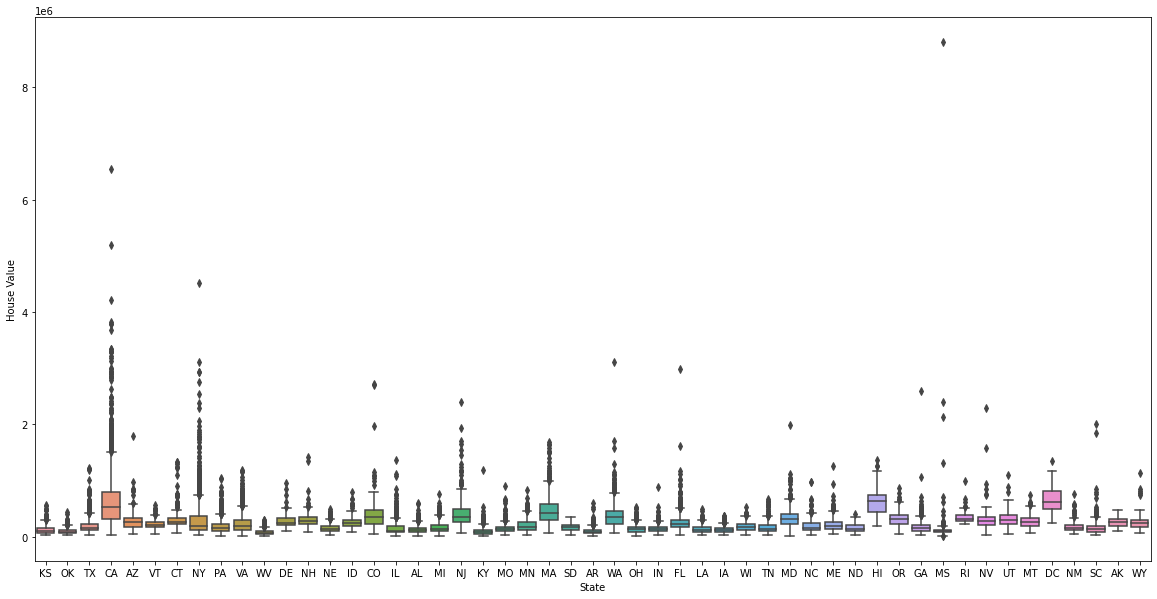

In [6]:
# lets groups the data and see how many zip code we have for each state
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(figsize=(20, 10))
ax = sns.boxplot(x="State", y="House Value", data=grouped_df[~grouped_df['House Value'].isnull()])

In [81]:
chosen_states = ['CA', 'FL', 'NY', 'MD', 'CO', 'NJ', 'MA', 'WA', 'IN', 'SC', 'GA', 'MS', 'WY', 'AZ', 'MO']
# lets check how many zip codes we have per each
byzip = grouped_df.groupby('State').count()
byzip = byzip.reset_index()[byzip.reset_index()['State'].isin(chosen_states)]

# let remove WY which only has 200 zip codes
# I want also to calculate where we have the lowest precentag eof house values to zip code
byzip['zip/house'] = byzip['House Value'] / byzip['Zip']

# AZ has 56% lest remove it as well
# our final list to work with will be 
chosen_states_updated = ['CA', 'FL', 'NY', 'MD', 'CO', 'NJ', 'MA', 'IN', 'SC', 'GA', 'MS', 'MO']
byzip = byzip[byzip['State'].isin(chosen_states_updated)]
byzip

,State,Zip,City,Latitude,Longitude,House Value,zip/house
4,CA,1664,1664,1664,1664,1664,1.0
5,CO,486,486,486,486,486,1.0
9,FL,932,932,932,932,932,1.0
10,GA,662,662,662,662,662,1.0
15,IN,800,800,800,800,800,1.0
19,MA,527,527,527,527,527,1.0
20,MD,464,464,464,464,464,1.0
24,MO,932,932,932,932,932,1.0
25,MS,365,365,365,365,365,1.0
31,NJ,587,587,587,587,587,1.0


In [215]:
byzip[['State', 'Zip']].transpose()

,4,5,9,10,15,19,20,24,25,31,34,40
State,CA,CO,FL,GA,IN,MA,MD,MO,MS,NJ,NY,SC
Zip,1664,486,932,662,800,527,464,932,365,587,1742,385


<h2> Part 3: Working with FS API</h2>
<p>
    My next goal in this project is to utilize the forsquare api and retrive the list of resturant around each location.
    Here is the link to the venues doc in case your intersted https://developer.foursquare.com/docs/api-reference/venues/search-enterprise//
    We will have to provide a param named ll with our geo locaiton data
    and the radius of venues we are looking for, the default is 250 m. Since we are working with zip code it should be enough.
    You can provide a category id to limit the result or leave it empty and get all venues.
    In this case I'm intersted only in the resturant data so we can find the category id in the doc and supply it with the request
    The category actually called food and bellow it segmented to types of resturant, the category id is 4d4b7105d754a06374d81259
</p>

In [49]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A max Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [50]:
def venues_around_zipcode(zipcode, lat, lng):
    # create the API request URL
    CATEGORYID = '4d4b7105d754a06374d81259'
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng,
        LIMIT,
        1000, # radius of 1000 m
        CATEGORYID)
    
    # make the GET request
    response = requests.get(url).json()["response"]
    # in case no venues just continue with a empty array
    if('venues' not in response):
        response = []
    else:
        response = response['venues']

    # formating the result
    # since it's a nested object we have to format it manully
    arr = [(zipcode,
        v['name'], 
        v['location']['distance'],
        v['location']['lat'], 
        v['location']['lng'],  
        v['categories'][0]['name'] if len(v['categories']) > 0 else np.nan) for v in response]
    
    return arr

In [ ]:
import time

# lets loop over each state zip codes and retrive the infomations
def getNearByForState(state_df):
    # select all zip codes in state
    zipcode, latitudes, longitudes = state_df['Zip'], state_df['Latitude'], state_df['Longitude']
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):        
        result = venues_around_zipcode(zipcode, lat, lng)
        venues_list.append(result)
        #time.sleep(0.5) # Sleep for 1 seconds -> api has limit rates
                                                                                     
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'Restaurant Name',
                  'Restaurant Distance', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    
    return(nearby_venues)

venues_aggregated = []
def helper_state(state):
    state_df = grouped_df[grouped_df['State'] == state]
    print('Start calling api for state of {} has {} zip codes'.format(state, len(state_df)))
    result = getNearByForState(state_df)
    
    venues_aggregated.append(result)
    print('Retrivied {} results'.format(len(result)))
    
    # since the api rate is limited, lets create a csv file of each state
    df = pd.DataFrame(result)
    df.to_csv('{}.csv'.format(state), encoding='utf-8')
                                                                                     
for state in chosen_states_updated:
    helper_state(state)
    
# venues to pd
aggregated_venued_df = pd.concat(venues_aggregated)
aggregated_venued_df.head()

<p>
    The script to getting the data from Forsquare is based on what we have done in the course.
    Just add a category to filter by resturants.
    I did have downloaded all the information and saved each state to there own file.
    I decided to download only some of the sates information, the reason will be explained in the final assigment, but the main goal was to save the numbers of calls to the api
</p>

<p>
Bellow is a code to read one of the csv files of location downloaded,
Create dummies variables of the file and display a summery of this information.
<br />
We can see that we have 197 different resturant categories in the state of NJ
This is split across 695 different zip codes and in total we have retrived 16901 different locations for this state.
   
</p>

<p>
    Since we have a lot of different categories my goal in the next step is to check if we have a few categories with very small number of resturants in the aggregated data, if so we can remove them.
    Also some of the venues in the data seems not like a resturants for example "Arcade" - I will go over the list of categories and check for others like this.
    
    Interestingly more then 50% of the venues we have retrived have less then 10 places corresponding to their category.
    We can consider removed them from our data set
</p>

In [52]:
# check one file data
def validate_file(state):
    df = pd.read_csv('{}.csv'.format(state))
    print('Number of zip codes is aray: ', len(df['ZipCode'].unique()))
    print('Number of restaurant catrgories is aray: ', len(df['Restaurant Category'].unique()))
    print('Number of data points: {}'.format(len(df)))
    
    df.groupby('ZipCode').count().reset_index().head(20)

    # create a new data frame with groupped venues
    # one hot encoding
    dummies = pd.get_dummies(df[['Restaurant Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    dummies['ZipCode'] = df['ZipCode']

    # move zipcide column to the first column
    fixed_columns = [dummies.columns[-1]]  + dummies.columns[:-1].to_list()
    dummies = dummies[fixed_columns]

    # aggregate by zip codes 
    groupped = dummies.groupby(['ZipCode']).mean().reset_index()
    
    # Draw a histogram counting number of resturants

    return groupped
    
res = validate_file('NJ')
res

Number of zip codes is aray:  695
Number of resturants catrgories is aray:  197
Number of data points: 16901


,ZipCode,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Assisted Living,Australian Restaurant,...,Thai Restaurant,Theme Restaurant,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yemeni Restaurant
0,7001,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
1,7002,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.020408,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
2,7003,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,...,0.023810,0.000000,0.0,0.0,0.0,0.0,0.02381,0.0,0.000000,0.0
3,7004,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
4,7005,0.0,0.0,0.023256,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.046512,0.023256,0.0,0.0,0.0,0.0,0.00000,0.0,0.023256,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,8922,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
691,8933,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
692,8988,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
693,8989,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0


In [79]:
# check one file data
def group_by_categories(state):
    df = pd.read_csv('{}.csv'.format(state))
    print('Number of zip codes is aray: ', len(df['ZipCode'].unique()))
    print('Number of restaurant catrgories is aray: ', len(df['Restaurant Category'].unique()))
    print('Number of data points: {}'.format(len(df)))
    
    grouped =  df.groupby('Restaurant Category').count().reset_index()

    # some stats
    lett_then_3 = grouped[grouped['ZipCode'] < 3]['Restaurant Category']
    print('Less then three restaurant in the category {} : ', len(lett_then_3))

    lett_then_10 = grouped[grouped['ZipCode'] < 10]['Restaurant Category']
    print('Less then then restaurant in the category {} : ', len(lett_then_10))


    
    return grouped.sort_values(by=['ZipCode'])
    
res = group_by_categories('NJ')
print(res[res['ZipCode'] < 5]['Restaurant Category'].to_numpy())

Number of zip codes is aray:  695
Number of resturants catrgories is aray:  197
Number of data points: 16901
Less then three resrutan in the category {} :  60
Less then then resrutan in the category {} :  101
['Yemeni Restaurant' 'Coworking Space' 'Puerto Rican Restaurant'
 'English Restaurant' 'Hungarian Restaurant' 'Pastry Shop'
 'Indonesian Restaurant' 'Outdoor Event Space' 'Other Great Outdoors'
 'Salvadoran Restaurant' 'Non-Profit' 'Cantonese Restaurant' 'Dive Bar'
 'Discount Store' 'Cheese Shop' 'Jazz Club' 'Karaoke Bar' 'Mini Golf'
 'Medical Center' 'Doner Restaurant' 'Brasserie' 'Hunan Restaurant'
 'Hotpot Restaurant' 'Fondue Restaurant' 'Arcade' 'Tiki Bar' 'Golf Course'
 'Sri Lankan Restaurant' 'Assisted Living' 'Event Service'
 'Soba Restaurant' 'Gym Pool' 'Social Club' 'Bank' 'Shanghai Restaurant'
 'Beach' 'Hookah Bar' 'Belgian Restaurant' 'Shopping Mall' 'Liquor Store'
 'Indian Chinese Restaurant' 'Health Food Store' 'Hotel Bar'
 'Kebab Restaurant' 'Korean BBQ Restaurant' '

In [204]:
# aggregate all data to data frame
aggregated_venues_df = pd.DataFrame()

for state in chosen_states_updated:
    df = pd.read_csv('{}.csv'.format(state))
    aggregated_venues_df = pd.concat([aggregated_venued_df, df])
    
print(aggregated_venues_df.shape)
aggregated_venues_df.head()

(333228, 7)


,Unnamed: 0,ZipCode,Restaurant Name,Restaurant Distance,Restaurant Latitude,Restaurant Longitude,Restaurant Category
0,0,92067,Morada Restaurant Santa Fe,333,33.018589,-117.205193,American Restaurant
1,1,92067,Thyme In the Ranch,300,33.019136,-117.203267,Tea Room
2,2,92067,Morada,309,33.018688,-117.204681,Restaurant
3,3,92067,Rancho Sandwich,374,33.019840,-117.203076,Sandwich Place
4,4,92067,Osuna Grill,1054,33.023982,-117.209560,Burger Joint


In [205]:
# remove the column 'Unnamed: 0'
aggregated_venues_df = aggregated_venues_df.drop(columns=['Unnamed: 0'])

In [206]:
# check for duplicated venues based on zip code and name
# even if in reallty we have the same place twice at the same zip code it's zero chances
duplicateRowsDF = aggregated_venues_df[aggregated_venues_df.duplicated(['ZipCode', 'Restaurant Name'])]
print(duplicateRowsDF.shape)

# drop duplicated keep only the first 
aggregated_venues_df.drop_duplicates(subset =['ZipCode', 'Restaurant Name'],  keep = 'first', inplace = True)

(173686, 6)


In [207]:
aggregated_venues_df.describe(include='all')

,ZipCode,Restaurant Name,Restaurant Distance,Restaurant Latitude,Restaurant Longitude,Restaurant Category
count,159542.000000,159542,159542.000000,159542.000000,159542.000000,159542
unique,NaN,83356,NaN,NaN,NaN,381
top,NaN,Starbucks,NaN,NaN,NaN,Pizza Place
freq,NaN,2048,NaN,NaN,NaN,11880
mean,42729.414725,NaN,742.894310,37.124796,-90.258079,NaN
std,34788.345403,NaN,373.545581,4.578216,19.050742,NaN
min,501.000000,NaN,2.000000,24.558931,-124.215610,NaN
25%,11042.000000,NaN,504.000000,33.797740,-117.610974,NaN
50%,32276.000000,NaN,767.000000,38.829881,-81.714637,NaN
75%,90221.000000,NaN,988.000000,40.759169,-74.073422,NaN


<p>
    Our data is categorical so we can't fully see it using the pandas describe method buy we can understand few intested things
    1. We have 160 Thousand resturant in our aggregated data frame with almost half of them uniques
    2. we have 381 different categoris
    3. Starbucks is the most common restaurant  
    <br />
    I'll try and remove categories which low number of resturants in them.
    We can simply group by the category and use the size operator.
    Applying the describe function on this df,  we find out the 50% of our categories have less then 10 resturants
    We can safly remove them an 
</p>

In [208]:
sized = aggregated_venues_df.groupby('Restaurant Category').size()
sized.describe()

count      381.000000
mean       418.745407
std       1349.130884
min          1.000000
25%          2.000000
50%         10.000000
75%         93.000000
max      11880.000000
dtype: float64

In [209]:
# lets get the list of those categories and remove them
categories_to_remove = sized[sized<=10].index.values

# remove all rows with those categories and save an aggregated file we will work with
aggregated_venues_df = aggregated_venues_df[~aggregated_venues_df['Restaurant Category'].isin(categories_to_remove)]
aggregated_venues_df.describe(include='all')

,ZipCode,Restaurant Name,Restaurant Distance,Restaurant Latitude,Restaurant Longitude,Restaurant Category
count,158917.000000,158917,158917.000000,158917.000000,158917.000000,158917
unique,NaN,82860,NaN,NaN,NaN,185
top,NaN,Starbucks,NaN,NaN,NaN,Pizza Place
freq,NaN,2048,NaN,NaN,NaN,11880
mean,42730.172537,NaN,742.821888,37.124323,-90.260162,NaN
std,34793.602174,NaN,373.781616,4.577528,19.053145,NaN
min,501.000000,NaN,2.000000,24.558931,-124.215610,NaN
25%,11041.000000,NaN,503.000000,33.797740,-117.611890,NaN
50%,32276.000000,NaN,767.000000,38.827727,-81.711740,NaN
75%,90221.000000,NaN,988.000000,40.759262,-74.073400,NaN


In [5]:
aggregated_venues_df = pd.read_csv('aggregated_venues.csv')
aggregated_venues_df.shape

(158917, 6)

In [6]:
# After sum digging I found out there is a category named food which is general and doesnt tell us anything
# I have no way to validate what kind of places those area and we have almost 5,000 like those
# out of those 5,000 we have 3,253 unique places
# I'm going to look for places with the same name and fill the category if it's different from food.

# Same problem with a category names Resturant which has around 4200 missing information point
# Replacing them as well with any data I can find

def replace_category(df, cat):
    print('Number of places with category {} : {}'.format(cat, len(df[df['Restaurant Category'] == cat])))

    names = df[df['Restaurant Category'] == cat]['Restaurant Name'].unique()
    # df of food category items
    food_cat_df = df[df['Restaurant Category'] == cat]
    # df on items with category different them food
    non_food_df = df[df['Restaurant Category'] != cat]
    # join them togther so we can have the right category
    #temp_df = food_cat_df.join(non_food_df.set_index('Restaurant Name'), on='Restaurant Name', how='inner', rsuffix='_right')

    # manually replace food category with other category of same business name:
    for index, row in food_cat_df.iterrows():
        # replace based on those with food cat and data from non food
        search_df = non_food_df[non_food_df['Restaurant Name'] == row['Restaurant Name']].head(1)
        if(len(search_df) > 0):
            #print(row['ZipCode'], row['Restaurant Name'])        
            cond = (df.ZipCode == row['ZipCode']) & (df['Restaurant Name'] == row['Restaurant Name'])
            df.loc[cond, 'Restaurant Category'] = search_df['Restaurant Category'].values[0]

    print('Number of places with category Food After Correction {} : {}'.format(cat, len(df[df['Restaurant Category'] == cat])))
    return df

In [7]:
aggregated_venues_df = replace_category(aggregated_venues_df , 'Food')
aggregated_venues_df = replace_category(aggregated_venues_df , 'Restaurant')

''' 
runing this correction we managed to fill up 500 food places and 600 restaurants
We still have almost 4300 mising foos places, and another __ categored as restaurans 
I'll remove those and continue with the rest, in total we'll be lossing 7,800 locations out of 150K

'''
aggregated_venues_df = aggregated_venues_df[aggregated_venues_df['Restaurant Category'] != 'Food']
aggregated_venues_df = aggregated_venues_df[aggregated_venues_df['Restaurant Category'] != 'Restaurant']
print(aggregated_venues_df.shape)

Number of places with category Food : 4808
Number of places with category Food After Correction Food : 4308
Number of places with category Restaurant : 4178
Number of places with category Food After Correction Restaurant : 3544
(151065, 6)


In [8]:
# check for duplicate locations
print('# before drop duplicated: ', aggregated_venues_df.shape)
aggregated_venues_df.drop_duplicates(subset =['ZipCode', 'Restaurant Name'],  keep = 'first', inplace = True) 
print('# after drop duplicated: ', aggregated_venues_df.shape)

# before drop duplicated:  (151065, 6)
# after drop duplicated:  (151065, 6)


In [9]:
# we are left with 191 unique categories and 151 thousand restaurants
# save the file to csv 
aggregated_venues_df.to_csv('aggregated_venues.csv', index=False)